In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install keras_applications
!pip install git+https://github.com/ma7555/keras-vggface.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 2s (3,113 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pytesseract as ocr
import dlib
from keras import applications, Model
from keras.layers import Flatten, Dense
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import math
from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [3]:
# use VGGFace model
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras.preprocessing import image

In [4]:
print("cv2: ", cv2.__version__)
print("numpy: ", np.__version__)
print("pytesseract: ", ocr.__version__)

cv2:  4.7.0
numpy:  1.24.3
pytesseract:  0.3.10


In [5]:
# download weights

!wget https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat -O "shape_predictor_68_face_landmarks.dat"
!wget https://raw.githubusercontent.com/kipr/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O "haarcascade_frontalface_default.xml"

--2023-05-20 04:32:54--  https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat [following]
--2023-05-20 04:32:54--  https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>] 

In [ ]:
# load weights
cascade_classifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
landmarks_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

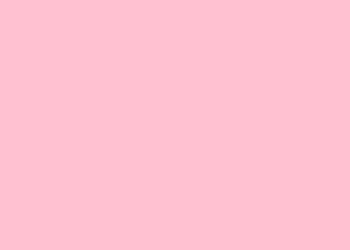

In [ ]:
height = 250
width = 350
blank_canvas = np.zeros((height, width, 3), np.uint8)
blank_canvas[:,0:width] = (209,193,255)
cv2_imshow(blank_canvas)

In [7]:
from sklearn.datasets import fetch_lfw_people

In [9]:
lfw_peoples = fetch_lfw_people(resize=0.8, min_faces_per_person=100)
names = lfw_peoples.target_names
images = lfw_peoples.images
y = lfw_peoples.target

In [10]:
len(y)

1140

In [11]:
len(images)

1140

In [12]:
len(names)

5

In [13]:
names

array(['Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Tony Blair'], dtype='<U17')

In [ ]:
classes = {}
for idx, target in enumerate(y):
  name = names[target]
  if name in classes:
    classes[names[target]].append(idx)
  else:
    classes[names[target]] = [idx] 

In [14]:
def mock_card_generator(image, name):
  height, width = (250, 350)
  v, h = (60, 30)
  text_v, text_h = (120, 80)
  canvas = np.zeros((height, width, 3), np.uint8)
  canvas[:,0:width] = (209,193,255)
  canvas[v:v+image.shape[0], h:h+image.shape[1]] = image
  cv2.putText(canvas, "Name", (text_v, text_h), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, 2)
  cv2.putText(canvas, name.upper(), (text_v, text_h + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1, 2)
  return canvas

In [ ]:
def remove_empty_lines(text):
  return "".join([s for s in text.strip().splitlines(True) if s.strip()])

In [ ]:
def get_name_from_image(image):
  text = ocr.image_to_string(image)
  lines = remove_empty_lines(text).splitlines()
  for idx, line in enumerate(lines):
    if (line == "Name"):
      return lines[idx + 1]
  return "No name found"

In [ ]:
def face_detection(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = cascade_classifier.detectMultiScale(gray, 1.05, 3)
  return faces

In [ ]:
def cropped(image, cropArea):
  x, y, w, h = cropArea
  return image[y:y+h, x:x+w]

In [ ]:
def remapped_facial_features_using_landmarks(image, landmarks):
  # cropped all the features first
  left_eye_roi = image[(landmarks.part(37).y - 10):(landmarks.part(41).y + 10), (landmarks.part(36).x - 10):(landmarks.part(39).x + 10)]
  right_eye_roi = image[(landmarks.part(43).y - 10):(landmarks.part(47).y + 10), (landmarks.part(42).x - 10):(landmarks.part(45).x + 10)]
  nose_roi = image[(landmarks.part(27).y - 10):(landmarks.part(33).y + 10), (landmarks.part(27).x - 10):(landmarks.part(33).x + 10)]
  mouth_roi = image[(landmarks.part(50).y - 10):(landmarks.part(57).y + 10), (landmarks.part(48).x - 10):(landmarks.part(54).x + 10)]
  # resize all features
  left_eye_roi = cv2.resize(left_eye_roi, (50, 50), interpolation=cv2.INTER_LINEAR)
  right_eye_roi = cv2.resize(right_eye_roi, (50, 50), interpolation=cv2.INTER_LINEAR)
  nose_roi = cv2.resize(nose_roi, (50, 50), interpolation=cv2.INTER_LINEAR)
  mouth_roi = cv2.resize(mouth_roi, (50, 50), interpolation=cv2.INTER_LINEAR)
  # concat features into single image
  concat_eyes = cv2.hconcat([left_eye_roi, right_eye_roi])
  concat_nose_mouth = cv2.hconcat([nose_roi, mouth_roi])
  remapped = cv2.vconcat([concat_eyes, concat_nose_mouth])
  return remapped

In [ ]:
def face_landmark_detector(image):
  dlib_face_detector = dlib.get_frontal_face_detector()
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = dlib_face_detector(image)
  for face in faces:
    landmarks = landmarks_predictor(gray, face)
    return landmarks
  return None

In [ ]:
def get_face_hog_features(image):
  IMG_HEIGHT = 256
  IMG_WIDTH = 128
  img_size = (IMG_WIDTH, IMG_HEIGHT)
  block_size = (64, 64)
  block_stride = (2, 2)
  cell_size = (8, 8)
  nbins = 9
  faces = face_detection(image)
  hog = cv2.HOGDescriptor(img_size, block_size, block_stride, cell_size, nbins)
  all_face_features = []
  for face in faces:
    x, y, w, h = face
    cropped = image[y:y+h, x:x+w]
    cropped = cv2.resize(cropped, img_size)
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    feature = hog.compute(gray)
    all_face_features.append(feature)
  return all_face_features


In [ ]:
def get_hog_features(image):
  IMG_HEIGHT = 256
  IMG_WIDTH = 128
  image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
  img_size = (IMG_WIDTH, IMG_HEIGHT)
  block_size = (64, 64)
  block_stride = (2, 2)
  cell_size = (8, 8)
  nbins = 9
  hog = cv2.HOGDescriptor(img_size, block_size, block_stride, cell_size, nbins)
  feature = hog.compute(image)
  return feature

In [ ]:
def hog_cosine_similarity(hog_one, hog_two):
  hog_one = hog_one / np.linalg.norm(hog_one)
  hog_two = hog_two / np.linalg.norm(hog_two)
  return np.inner(np.transpose(hog_one), np.transpose(hog_two))

In [ ]:
def resnet50_feature_extractor(image, **kwargs):
  image = cv2.resize(image, (224, 224))
  image = np.reshape(image, (1, 224, 224, 3))  # reshape to (batch_size, height, width, channels)
  model = applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    **kwargs)
  x = Flatten()(model.output)
  feature_extractor = Model(
   inputs=model.inputs,
   outputs=x)
  return feature_extractor(image)

In [ ]:
def vgg16_feature_extractor(image, **kwargs):
  image = cv2.resize(image, (224, 224))
  image = np.reshape(image, (1, 224, 224, 3))  # reshape to (batch_size, height, width, channels)
  model = applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    **kwargs)
  x = Flatten()(model.output)
  feature_extractor = Model(
   inputs=model.inputs,
   outputs=x)
  return feature_extractor(image)

In [ ]:
def vgg19_feature_extractor(image, **kwargs):
  image = cv2.resize(image, (224, 224))
  image = np.reshape(image, (1, 224, 224, 3))  # reshape to (batch_size, height, width, channels)
  model = applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    **kwargs)
  x = Flatten()(model.output)
  feature_extractor = Model(
   inputs=model.inputs,
   outputs=x)
  return feature_extractor(image)

In [ ]:
def vggface_feature_extractor(image, **kwargs):
  model = VGGFace(
        model='vgg16',
        include_top=False,
        input_shape=(224, 224, 3))
  
  image = cv2.resize(image, (224, 224))
  image = np.reshape(image, (1, 224, 224, 3))
  vggface_features = model.layers[-1].output
  feature_extractor = Model(inputs=model.input, outputs=vggface_features)
  return feature_extractor(image)

In [ ]:
def calculate_euclidean_distance(vector1, vector2):
  return np.linalg.norm(vector1 - vector2)

In [ ]:
def calculate_cosine_similarity(vector1, vector2):
  dot_product = np.dot(vector1, vector2)
  norm_1 = vector1 / np.linalg.norm(vector1)
  norm_2 = vector2 / np.linalg.norm(vector2)
  return dot_product / (norm_1 * norm_2)

In [ ]:
def extract_face_features(faceImg):
  print("faceImg")

In [ ]:
# def get_eigenface_features(face):


In [ ]:
# cls_features = {}
# iter = tqdm(classes)
# for cls in iter:
#   iter.set_postfix({"current cls": cls})
#   image_idx = classes[cls][0]
#   img = cv2.cvtColor(images[image_idx] * 255, cv2.COLOR_GRAY2BGR)
#   cls_features[cls] = np.squeeze(cnn_feature_extractor(img))

In [18]:
# genenate a bunch of mock_cards with LFW dataset
mock_cards = []
# iter = tqdm(enumerate(images))
for idx, target in tqdm(enumerate(y), total=len(y)):
  name = names[target]
  face = cv2.cvtColor(images[idx] * 255, cv2.COLOR_GRAY2BGR)
  mock_card = mock_card_generator(face, name)
  mock_cards.append(mock_card)

100%|██████████| 1140/1140 [00:01<00:00, 767.75it/s]


In [ ]:
# generate reference gallary
gallary_hog = {}
iter = tqdm(classes)
for cls in iter:
  image_idx = classes[cls][0]
  img = cv2.cvtColor(images[image_idx] * 255, cv2.COLOR_GRAY2BGR)
  mock = mock_card_generator(img, cls)
  gallary_hog[cls] = get_face_hog_features(mock)[0]

100%|██████████| 5/5 [00:01<00:00,  3.77it/s]


In [ ]:
ground_y = []
# use HOG with cosian similarity
hog_features = []
for idx, card in tqdm(enumerate(mock_cards), total=len(mock_cards)):
  hogs = get_face_hog_features(card)
  # hogs = get_face_hog_features(mock_cards[idx])
  if len(hogs) == 0:
    continue
  hog = hogs[0]
  hog_features.append(hog)
  ground_y.append(y[idx])

100%|██████████| 1140/1140 [03:32<00:00,  5.36it/s]


In [ ]:
y_pred = np.array([])
# make predictions
for hog in tqdm(hog_features):
  scores = {}
  for key, value in gallary_hog.items():
    cos_sims = hog_cosine_similarity(hog, value)
    scores[key] = cos_sims
  pred = max(scores, key=scores.get)
  y_pred = np.append(y_pred, np.where(names == pred)[0][0])

100%|██████████| 1136/1136 [00:34<00:00, 33.18it/s]


In [ ]:
print("HOG with Cosine Similary accuracy: ", accuracy_score(y_pred, ground_y))

HOG with Cosine Similary accuracy:  0.4647887323943662


In [ ]:
# use HOG with euclidean distance
y_pred = np.array([])
# make predictions
for hog in tqdm(hog_features):
  scores = {}
  for key, value in gallary_hog.items():
    dist = calculate_euclidean_distance(hog, value)
    scores[key] = dist
  pred = min(scores, key=scores.get)
  y_pred = np.append(y_pred, np.where(names == pred)[0][0])

100%|██████████| 1136/1136 [00:14<00:00, 78.14it/s]


In [ ]:
print("HOG with Euclidean Distance accuracy: ", accuracy_score(y_pred, ground_y))

HOG with Euclidean Distance accuracy:  0.4647887323943662


In [ ]:
# clear memory
hog_features = []

In [ ]:
ground_y = []
resnet50_features = []
for idx, card in tqdm(enumerate(mock_cards), total=len(mock_cards)):
  face_roi = face_detection(card)
  if (len(face_roi) == 0):
    continue
  feat = np.squeeze(resnet50_feature_extractor(cropped(card, face_roi[0])))
  resnet50_features.append(feat)
  ground_y.append(y[idx])

  0%|          | 0/1140 [00:00<?, ?it/s]

94765736/94765736 [==============================] - 1s 0us/step


100%|██████████| 1140/1140 [57:15<00:00,  3.01s/it]


In [ ]:
# generate reference gallary
gallary_cnn = {}
iter = tqdm(classes)
for cls in iter:
  image_idx = classes[cls][0]
  img = cv2.cvtColor(images[image_idx] * 255, cv2.COLOR_GRAY2BGR)
  mock = mock_card_generator(img, cls)
  face_roi = face_detection(mock)[0]
  feat = np.squeeze(resnet50_feature_extractor(cropped(mock, face_roi)))
  gallary_cnn[cls] = feat

100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


In [ ]:
# use CNN with euclidean distance
y_pred = np.array([])
for cnn in tqdm(resnet50_features):
  scores = {}
  for key, value in gallary_cnn.items():
    dist = calculate_euclidean_distance(cnn, value)
    scores[key] = dist
  pred = min(scores, key=scores.get)
  y_pred = np.append(y_pred, np.where(names == pred)[0][0])

100%|██████████| 1136/1136 [00:00<00:00, 2417.91it/s]


In [ ]:
print("ResNet50-based feature extractor with euclidean distance: ", accuracy_score(y_pred, ground_y))

ResNet50-based feature extractor with euclidean distance:  0.5017605633802817


In [ ]:
resnet50_features = []

In [ ]:
gallary_cnn = {}
iter = tqdm(classes)
for cls in iter:
  image_idx = classes[cls][0]
  img = cv2.cvtColor(images[image_idx] * 255, cv2.COLOR_GRAY2BGR)
  mock = mock_card_generator(img, cls)
  face_roi = face_detection(mock)[0]
  feat = np.squeeze(vgg16_feature_extractor(cropped(mock, face_roi)))
  gallary_cnn[cls] = feat

  0%|          | 0/5 [00:00<?, ?it/s]

58889256/58889256 [==============================] - 1s 0us/step


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


In [ ]:
ground_y = []
vgg16_features = []
for idx, card in tqdm(enumerate(mock_cards), total=len(mock_cards)):
  face_roi = face_detection(card)
  if (len(face_roi) == 0):
    continue
  feat = np.squeeze(vgg16_feature_extractor(cropped(card, face_roi[0])))
  vgg16_features.append(feat)
  ground_y.append(y[idx])

100%|██████████| 1140/1140 [24:25<00:00,  1.29s/it]


In [ ]:
# use VGG16 with euclidean distance
y_pred = np.array([])
# make predictions
for feat in tqdm(vgg16_features):
  scores = {}
  for key, value in gallary_cnn.items():
    dist = calculate_euclidean_distance(feat, value)
    scores[key] = dist
  pred = min(scores, key=scores.get)
  y_pred = np.append(y_pred, np.where(names == pred)[0][0])

100%|██████████| 1136/1136 [00:00<00:00, 8940.88it/s]


In [ ]:
print("VGG16-based feature extractor with euclidean distance: ", accuracy_score(y_pred, ground_y))

VGG16-based feature extractor with euclidean distance:  0.3617957746478873


In [ ]:
vgg16_features = []

In [ ]:
gallary_cnn = {}
iter = tqdm(classes)
for cls in iter:
  image_idx = classes[cls][0]
  img = cv2.cvtColor(images[image_idx] * 255, cv2.COLOR_GRAY2BGR)
  mock = mock_card_generator(img, cls)
  face_roi = face_detection(mock)[0]
  feat = np.squeeze(vgg19_feature_extractor(cropped(mock, face_roi)))
  gallary_cnn[cls] = feat

  0%|          | 0/5 [00:00<?, ?it/s]

80134624/80134624 [==============================] - 1s 0us/step


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


In [ ]:
ground_y = []
vgg19_features = []
for idx, card in tqdm(enumerate(mock_cards), total=len(mock_cards)):
  face_roi = face_detection(card)
  if (len(face_roi) == 0):
    continue
  feat = np.squeeze(vgg19_feature_extractor(cropped(card, face_roi[0])))
  vgg19_features.append(feat)
  ground_y.append(y[idx])

100%|██████████| 1140/1140 [30:33<00:00,  1.61s/it]


In [ ]:
# use VGG19 with euclidean distance
y_pred = np.array([])
# make predictions
for feat in tqdm(vgg19_features):
  scores = {}
  for key, value in gallary_cnn.items():
    dist = calculate_euclidean_distance(feat, value)
    scores[key] = dist
  pred = min(scores, key=scores.get)
  y_pred = np.append(y_pred, np.where(names == pred)[0][0])

100%|██████████| 1136/1136 [00:00<00:00, 8527.65it/s]


In [ ]:
print("VGG19-based feature extractor with euclidean distance: ", accuracy_score(y_pred, ground_y))

VGG19-based feature extractor with euclidean distance:  0.3160211267605634


In [ ]:
vgg19_features = []

In [ ]:
gallary_cnn = {}
iter = tqdm(classes)
for cls in iter:
  image_idx = classes[cls][0]
  img = cv2.cvtColor(images[image_idx] * 255, cv2.COLOR_GRAY2BGR)
  mock = mock_card_generator(img, cls)
  face_roi = face_detection(mock)[0]
  feat = np.squeeze(vggface_feature_extractor(cropped(mock, face_roi)))
  gallary_cnn[cls] = feat

  0%|          | 0/5 [00:00<?, ?it/s]

58909280/58909280 [==============================] - 0s 0us/step


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


In [ ]:
ground_y = []
vggface_features = []
for idx, card in tqdm(enumerate(mock_cards), total=len(mock_cards)):
  face_roi = face_detection(card)
  if (len(face_roi) == 0):
    continue
  feat = np.squeeze(vggface_feature_extractor(cropped(card, face_roi[0])))
  vggface_features.append(feat)
  ground_y.append(y[idx])

100%|██████████| 1140/1140 [22:07<00:00,  1.16s/it]


In [ ]:
# use VGGFace with euclidean distance
y_pred = np.array([])
# make predictions
for feat in tqdm(vggface_features):
  scores = {}
  for key, value in gallary_cnn.items():
    dist = calculate_euclidean_distance(feat, value)
    scores[key] = dist
  pred = min(scores, key=scores.get)
  y_pred = np.append(y_pred, np.where(names == pred)[0][0])

100%|██████████| 1136/1136 [00:00<00:00, 8520.10it/s]


In [ ]:
print("VGGFace-based feature extractor with euclidean distance: ", accuracy_score(y_pred, ground_y))

VGGFace-based feature extractor with euclidean distance:  0.6690140845070423


Here I attempt to improve the accuracy by remapping the facial features

In [ ]:
# generate reference gallary
gallary_hog = {}
iter = tqdm(classes)
for cls in iter:
  image_idx = classes[cls][0]
  img = cv2.cvtColor(images[image_idx] * 255, cv2.COLOR_GRAY2BGR)
  mock = mock_card_generator(img, cls)
  landmarks = face_landmark_detector(mock)
  remapped = remapped_facial_features_using_landmarks(mock, landmarks)
  gallary_hog[cls] = get_hog_features(remapped)

100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


In [ ]:
remapped_faces = []
ground_y = []
# for idx, card in tqdm(enumerate(mock_cards), total=len(mock_cards)):
for idx in tqdm(range(500)):
  # landmarks = face_landmark_detector(card)
  landmakrs = face_landmark_detector(mock_cards[idx])
  if landmarks == None or landmarks.num_parts == 0:
    continue
  remapped = remapped_facial_features_using_landmarks(mock_cards[idx], landmarks)
  remapped_faces.append(remapped)
  ground_y.append(y[idx])

100%|██████████| 500/500 [04:51<00:00,  1.71it/s]


In [ ]:
mock_cards = [] # clear memory

In [ ]:
# use HOG with cosian similarity
hog_features = []
for remapped in tqdm(remapped_faces):
  hog = get_hog_features(remapped)
  hog_features.append(hog)

100%|██████████| 500/500 [01:00<00:00,  8.27it/s]


In [ ]:
y_pred = np.array([])
# make predictions
for hog in tqdm(hog_features):
  scores = {}
  for key, value in gallary_hog.items():
    cos_sims = hog_cosine_similarity(hog, value)
    scores[key] = cos_sims
  pred = max(scores, key=scores.get)
  y_pred = np.append(y_pred, np.where(names == pred)[0][0])

100%|██████████| 500/500 [00:14<00:00, 33.52it/s]


In [ ]:
print("HOG with Cosine Similary accuracy: ", accuracy_score(y_pred, ground_y))

HOG with Cosine Similary accuracy:  0.418


In [ ]:
# clear memory
hog_features = []

In [ ]:
# generate reference gallary
gallary_cnn = {}
iter = tqdm(classes)
for cls in iter:
  image_idx = classes[cls][0]
  img = cv2.cvtColor(images[image_idx] * 255, cv2.COLOR_GRAY2BGR)
  mock = mock_card_generator(img, cls)
  landmarks = face_landmark_detector(mock)
  remapped = remapped_facial_features_using_landmarks(mock, landmarks)
  feat = np.squeeze(resnet50_feature_extractor(remapped))
  gallary_cnn[cls] = feat

100%|██████████| 5/5 [00:29<00:00,  5.96s/it]


In [ ]:
resnet50_features = []
for img in tqdm(remapped_faces):
  feat = np.squeeze(resnet50_feature_extractor(img))
  resnet50_features.append(feat)

100%|██████████| 500/500 [24:24<00:00,  2.93s/it]


In [ ]:
# use CNN with euclidean distance
y_pred = np.array([])
for cnn in tqdm(resnet50_features):
  scores = {}
  for key, value in gallary_cnn.items():
    dist = calculate_euclidean_distance(cnn, value)
    scores[key] = dist
  pred = min(scores, key=scores.get)
  y_pred = np.append(y_pred, np.where(names == pred)[0][0])

100%|██████████| 500/500 [00:00<00:00, 1989.58it/s]


In [ ]:
print("ResNet50-based feature extractor with euclidean distance: ", accuracy_score(y_pred, ground_y))

ResNet50-based feature extractor with euclidean distance:  0.28


In [ ]:
resnet50_features = []

In [ ]:
# generate reference gallary
gallary_cnn = {}
iter = tqdm(classes)
for cls in iter:
  image_idx = classes[cls][0]
  img = cv2.cvtColor(images[image_idx] * 255, cv2.COLOR_GRAY2BGR)
  mock = mock_card_generator(img, cls)
  landmarks = face_landmark_detector(mock)
  remapped = remapped_facial_features_using_landmarks(mock, landmarks)
  feat = np.squeeze(vggface_feature_extractor(remapped))
  gallary_cnn[cls] = feat

100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


In [ ]:
vggface_features = []
for img in tqdm(remapped_faces):
  feat = np.squeeze(vggface_feature_extractor(img))
  vggface_features.append(feat)

100%|██████████| 500/500 [09:03<00:00,  1.09s/it]


In [ ]:
# use VGGFace with euclidean distance
y_pred = np.array([])
# make predictions
for feat in tqdm(vggface_features):
  scores = {}
  for key, value in gallary_cnn.items():
    dist = calculate_euclidean_distance(feat, value)
    scores[key] = dist
  pred = min(scores, key=scores.get)
  y_pred = np.append(y_pred, np.where(names == pred)[0][0])

100%|██████████| 500/500 [00:00<00:00, 7459.94it/s]


In [ ]:
print("VGGFace-based feature extractor with euclidean distance: ", accuracy_score(y_pred, ground_y[:500]))

VGGFace-based feature extractor with euclidean distance:  0.29


In [ ]:
# Train a siamease network
import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Subtract
from keras.models import Model
from keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_pairs
import numpy as np

# Load the LFW dataset
lfw_pairs = fetch_lfw_pairs(subset='train', color=False)

# Get the image pairs and labels
pairs_train = lfw_pairs.pairs
y_train = lfw_pairs.target

# Extract the images from the pairs and preprocess the data
x_train = np.zeros((len(pairs_train), 2, 62, 47, 1), dtype=np.float32)
for i, pair in enumerate(pairs_train):
    x_train[i, 0] = (pair[0] / 255.0).reshape((62, 47, 1))
    x_train[i, 1] = (pair[1] / 255.0).reshape((62, 47, 1))

# Split the dataset into anchor and positive pairs
x_anchor_train = x_train[:, 0]
x_positive_train = x_train[:, 1]

# Get the negative pairs
x_negative_train = []
for i in range(len(x_anchor_train)):
    idx = np.random.choice(np.where(y_train != y_train[i])[0])
    x_negative_train.append(x_train[idx, 0])
x_negative_train = np.array(x_negative_train)

# Combine the anchor, positive, and negative pairs into input pairs
input_pairs_train = [x_anchor_train, x_positive_train, x_negative_train]

# Define the architecture of the Siamese network
input_shape = (62, 47, 1)
input_anchor = Input(shape=input_shape, name='anchor')
input_positive = Input(shape=input_shape, name='positive')
input_negative = Input(shape=input_shape, name='negative')

conv1 = Conv2D(16, 3, activation='relu', padding='same')
conv2 = Conv2D(16, 3, activation='relu', padding='same')
pool1 = MaxPooling2D((2,2), padding='same')
flatten = Flatten()
dense1 = Dense(50, activation='relu')

def siamese_dataset(pairs, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((pairs, labels))
    dataset = dataset.shuffle(buffer_size=len(pairs))
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda x, y: ((x[:, 0], x[:, 1]), y))  # Return a tuple of two elements
    return dataset

# Define the Siamese network as a model with two inputs and one output
input_shape = (62, 47, 1)
input_anchor = Input(shape=input_shape, name='anchor')
input_positive = Input(shape=input_shape, name='positive')

conv1 = Conv2D(32, (3,3), activation='relu', padding='same')
pool1 = MaxPooling2D((2,2), padding='same')
conv2 = Conv2D(64, (3,3), activation='relu', padding='same')
pool2 = MaxPooling2D((2,2), padding='same')
flatten = Flatten()
dense1 = Dense(128, activation='relu')

def siamese_network(inputs):
    x = conv1(inputs)
    x = conv2(x)
    x = pool1(x)
    x = flatten(x)
    x = dense1(x)
    return x

encoded_anchor = siamese_network(input_anchor)
encoded_positive = siamese_network(input_positive)

# Define the similarity measure between the outputs of the Siamese network
def L1_distance(x):
    return tf.abs(x[0] - x[1])

positive_distance = Lambda(L1_distance)([encoded_anchor, encoded_positive])

# Define the final output of the Siamese network
output = Dense(1, activation='sigmoid')(positive_distance)

# Define the Siamese network as a model with two inputs and one output
model = Model(inputs=[input_anchor, input_positive], outputs=output)

# Compile the model with the contrastive loss function and Adam optimizer
margin = 1
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=Adam(lr=0.0001))

# Train the Siamese network on the LFW dataset
batch_size = 32
num_epochs = 20
train_dataset = siamese_dataset(x_train, y_train, batch_size)
steps_per_epoch = len(x_train) // batch_size
history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=num_epochs)

NameError: ignored

In [ ]:
# Load the LFW dataset
lfw_pairs_test = fetch_lfw_pairs(subset='test', color=False)

# Get the image pairs and labels
pairs_test = lfw_pairs_test.pairs
y_test = lfw_pairs_test.target

# # Extract the images from the pairs and preprocess the data
# x_test = np.zeros((len(pairs_test), 2, 62, 47), dtype=np.float32)
# for i, pair in enumerate(pairs_test):
#     x_test[i, 0] = (pair[0] / 255.0).reshape((62, 47, 1))
#     x_test[i, 1] = (pair[1] / 255.0).reshape((62, 47, 1))

# Split the dataset into anchor and positive pairs
x_anchor_test = x_test[:, 0]
x_positive_test = x_test[:, 1]

# Get the negative pairs
x_negative_test = []
for i in range(len(x_anchor_test)):
    idx = np.random.choice(np.where(y_test != y_test[i])[0])
    x_negative_test.append(x_test[idx, 0])
x_negative_test = np.array(x_negative_test)

# Combine the anchor, positive, and negative pairs into input pairs
input_pairs_test = [x_anchor_test, x_positive_test]

# Compute the predicted similarity scores for the test set
y_pred = model.predict(input_pairs_test)

# Threshold the scores to obtain binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Compute accuracy
accuracy = np.mean(y_pred_binary == y_test)
print('Accuracy:', accuracy)


In [ ]:
input_shape